#Desafio Técnico - Case Gerencianet

  <img src='https://gerencianet.com.br/wp-content/themes/Gerencianet/assets/images/portal-da-marca/versoes-da-marca/horizontal/gerencianet-horizontal-colorido.svg' width=550px>

Autor: Lucas Alexandre Santos | [LinkedIn](https://www.linkedin.com/in/lucasabo)

Metodologia: CRISP-DM

#1- Entendimento do negócio

##1.1 Contexto
* "A Gerencianet é a empresa parceira que acredita no empreendedorismo e quer transformar sonhos em realidade.". Ela atua fornecendo conta digital e serviços financeiros para outras empresas. Atualmente a Gerencianet possui mais de: 290 mil contas ativas, 130 milhões de emissões anuais e só em 2021 movimentou R$ 30 bilhões.

* Sabe-se que um dos principais desafios do setor financeiro é a prática de fraudes. Estima-se que este problema custa mais de 1 bilhão de reais por ano ao setor brasileiro. 

* Diante desse contexto, a Gerencianet busca, através da sua Diretoria Antifraude, contornar o problema através de uma postura orientada a dados. 

##1.2 Objetivo de negócio
* Identificar e eliminar as contas ilícitas.

##1.3 Objetivo de mineração de dados
* Construir um modelo supervisionado capaz de classificar, com base em dados históricos e cadastrais, se a conta é ilícita (tipo F) ou não.

##1.4 Critério de sucesso
* Construção de um modelo com acurácia, f1-score e roc-auc superiores a 0.90 em uma base de testes.

#2- Entendimento dos dados

##2.1 Coleta e descrição inicial dos dados

###Importando as bibliotecas

In [4]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

###Importando os dados

Transformando as tabelas em dataframes através de queries

In [6]:
# Query 1 - Tabelas Accounts + Address + Levels

con = sqlite3.connect('/content/drive/MyDrive/Case_Gerencianet_Lucas_Alexandre/desafio-tecnico.db')

accounts = pd.read_sql_query('SELECT accounts.id, accounts.account_number, accounts.birth, accounts.occupation, \
                            accounts.created_at, address.state, levels.level \
                            FROM accounts \
                            LEFT JOIN address \
                            ON accounts.address_id = address.id \
                            LEFT JOIN levels \
                            ON accounts.account_number = levels.account_number', 
                            con, parse_dates=['birth', 'created_at'])

accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1029 non-null   int64         
 1   account_number  1029 non-null   int64         
 2   birth           1029 non-null   datetime64[ns]
 3   occupation      1029 non-null   object        
 4   created_at      1029 non-null   datetime64[ns]
 5   state           1029 non-null   object        
 6   level           926 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 56.4+ KB


Nota-se que apenas a coluna 'level' apresenta registros nulos (n=103). 

Iremos prever o 'level' destas contas, isto é, se elas são ilícitas ou não com base em um modelo preditivo.

In [7]:
# Query 2 - Tabela Charges

charges = pd.read_sql_query('SELECT * FROM charges', con, parse_dates=['created_at'])

charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154469 entries, 0 to 154468
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              154469 non-null  int64         
 1   account_number  154469 non-null  int64         
 2   status          154469 non-null  object        
 3   value           154469 non-null  int64         
 4   created_at      154469 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.9+ MB


A tabela apresenta 0 valores nulos e formatos adequados.

In [8]:
# Query 3 - Tabelas Transactions + Transactions_type

transactions = pd.read_sql_query('SELECT transactions.account_number, transactions.value, \
                                  transactions.created_at as transaction_date, transaction_type.description \
                                  FROM transactions \
                                  LEFT JOIN transaction_type \
                                  ON transactions.transaction_type_id = transaction_type.id',
                                 con, parse_dates=['transaction_date'])
con.close()

transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256227 entries, 0 to 256226
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account_number    256227 non-null  int64         
 1   value             256227 non-null  int64         
 2   transaction_date  256227 non-null  datetime64[ns]
 3   description       256227 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.8+ MB


Novamente, não foram observados valores nulos e os formatos estão corretos.

## 2.2 Análise exploratória dos dados

Nesta etapa foi feita uma análise com o intuito de descrever, explorar e analisar a qualidade de cada conjunto de dados.

Com base nos resultados será feita a integração dos dados, limpeza, contrução de novas variáveis e seleção de dados (vide tópico 3.0 - Data Preparation).



###Tabela Accounts

In [9]:
# Função para transformar a classe da conta na flag.
# Conta lícita = 0, ilícita = 1, nan = nan

def is_ilicit(x):
  if x in ['A', 'B', 'C', 'D']:
    return 0
  elif x == 'F':
    return 1
  else:
    return x

In [10]:
# Nova coluna com a flag

accounts['ilicit'] = accounts['level'].apply(is_ilicit)  

In [11]:
# Visualizando as 3 primeiras linhas

accounts.head(3)

,id,account_number,birth,occupation,created_at,state,level,ilicit
0,1,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,F,1.0
1,2,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,D,0.0
2,3,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,None,NaN


In [12]:
# Contagem de valores únicos por coluna

accounts.nunique()

id                1029
account_number    1029
birth              992
occupation           6
created_at         911
state                8
level                5
ilicit               2
dtype: int64

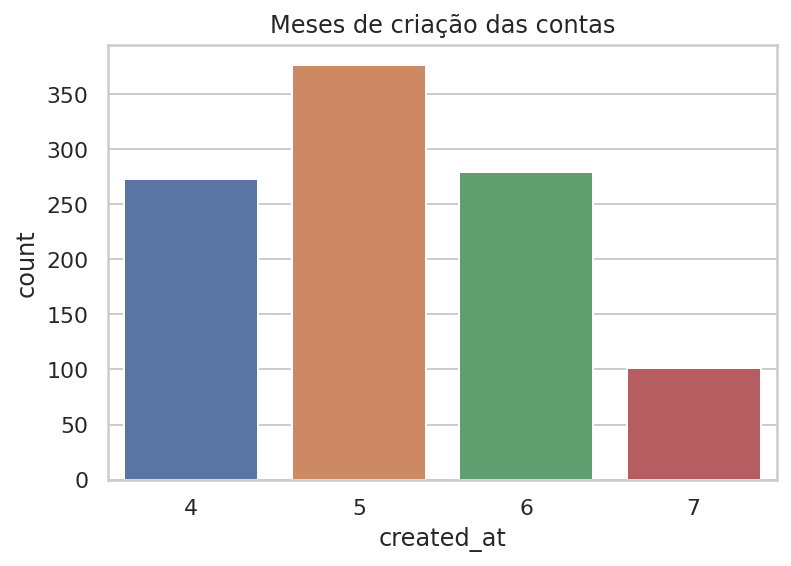

In [13]:
#Plotando a contagem de registros por mês de criação da conta
sns.set_theme(style='whitegrid')
sns.set_context('notebook')

plt.title('Meses de criação das contas')

sns.countplot(x=accounts['created_at'].dt.month)

plt.show()

Maio foi o mês no qual mais contas foram registradas.

Julho, apresenta 40% menos registros. Possivelmente os dados desse mês estão incompletos. 

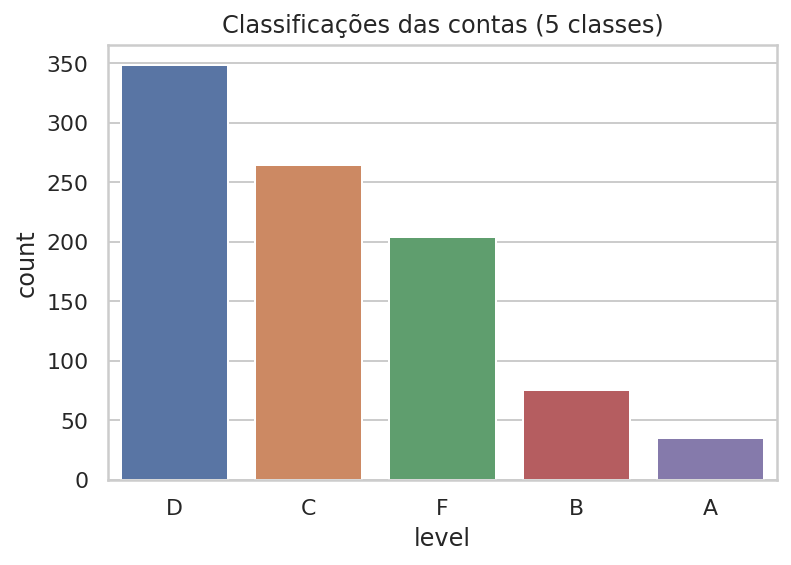

In [14]:
# Plotando a contagem de registros por classificação (level)

plt.title('Classificações das contas (5 classes)')

sns.countplot(x=accounts['level'], 
              order=accounts['level'].value_counts().index)

plt.show()

A categoria alvo (F), é a 3º mais comum. Representando cercar de 20% da base.

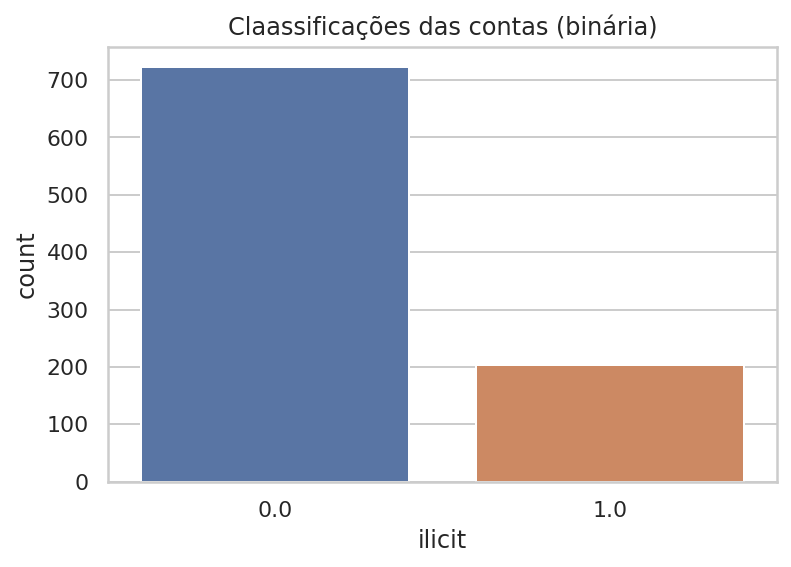

In [15]:
# Plotando a contagem de registros por classificação binária

plt.title('Claassificações das contas (binária)')

sns.countplot(x=accounts['ilicit'])

plt.show()

Observa-se que as classes estão desbalanceadas, em casos assim é possível utilizar técnicas como Random Undersampling/Oversampling.

Inicialmente, utilizarei a proporção original. Caso a performance do modelo seja insatisfatória, tratarei o desbalanceamento.

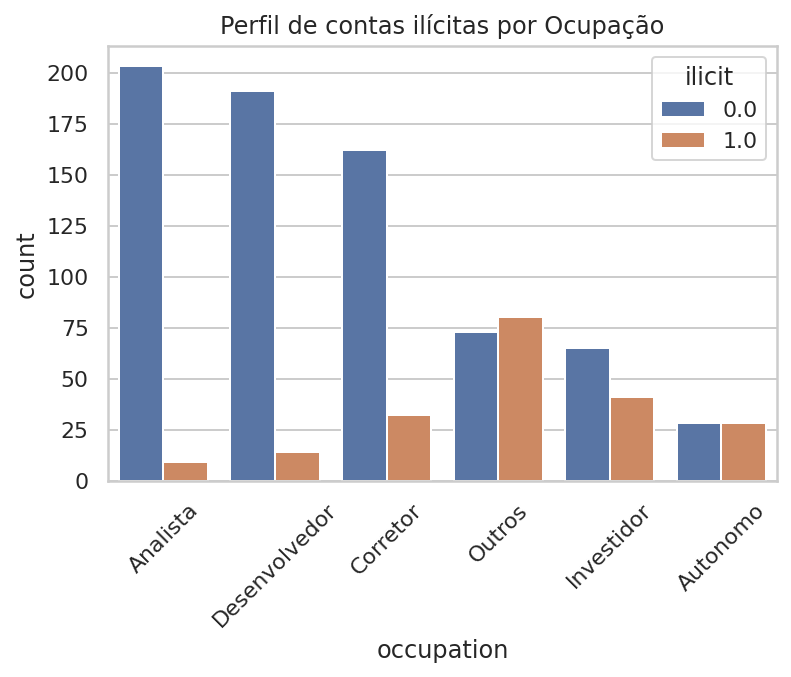

In [16]:
# Plotando a contagem de contas ilícitas por ocupação

plt.title('Perfil de contas ilícitas por Ocupação')

sns.countplot(x=accounts['occupation'], 
              order=accounts['occupation'].value_counts().index,
              hue=accounts['ilicit'])
plt.xticks(rotation=45)

plt.show()

As ocupações mais frequentes são os cargos de Analista, Desenvolvedor e Corretor. Essas funções também são as que apresentam as menores taxas de fraude.

A classe 'Outros' apresentam o maior volume de contas ilícitas.

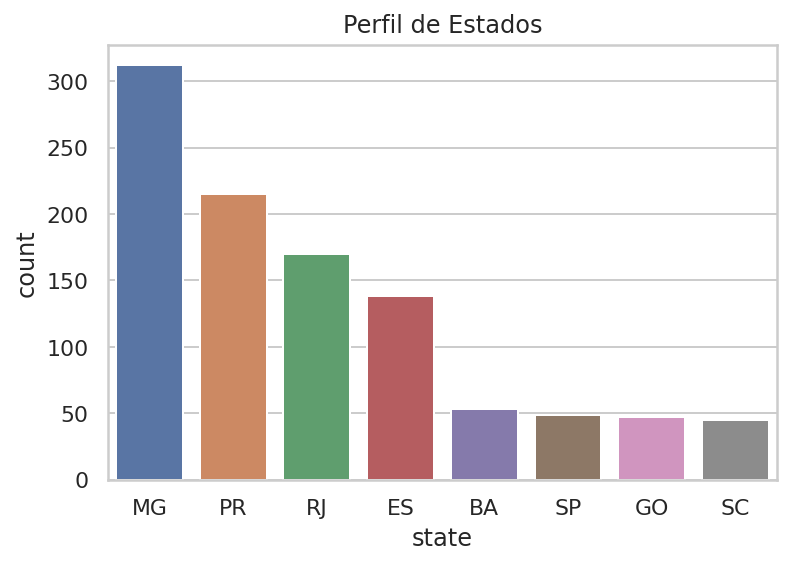

In [17]:
# Plotando a contagem de registros por estado

plt.title('Perfil de Estados')

sns.countplot(x=accounts['state'], 
              order=accounts['state'].value_counts().index)

plt.show()

Minas Gerais é o estado mais frequente, possivelmente devido a uma das sedes da empresa estar localizada neste estado.

Curiosamente, o estado brasileiro mais populoso (400 mi) e com o maior número de CNPJ ativos (1.8 mi), São Paulo, está entre os últimos da lista.  

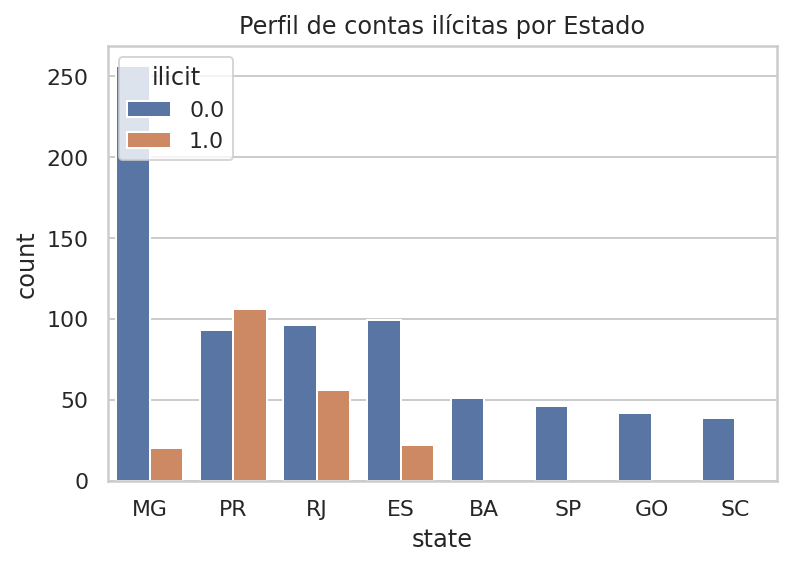

In [18]:
# Plotando a contagem de registros de contas ilícitas por estado

plt.title('Perfil de contas ilícitas por Estado')

sns.countplot(x=accounts['state'], 
              order=accounts['state'].value_counts().index,
              hue=accounts['ilicit'])

plt.show()

Embora apresente o maior número de contas, o estado de Minas Gerais apresenta uma baixa proporção de contas ilícitas.

Paraná e Rio de Janeiro se destacam pela proporção de contas fraudulentas. Sendo que  estado PR, 2º maior em nº de clientes, apresenta mais contas ilícitas do que lícitas.

###Tabela Charges

In [19]:
# Visualizando as 3 primeiras linhas

charges.head(3)

,id,account_number,status,value,created_at
0,1,155938,paid,11992,2021-04-01 03:00:00
1,2,155938,paid,9689,2021-04-01 13:30:00
2,3,155938,paid,11579,2021-04-01 11:30:00


In [20]:
# Transformando os valores de cobrança em reais (R$) 

charges['value'] = charges['value'] / 100

In [21]:
# Contagem de valores únicos por coluna

charges.nunique()

id                154469
account_number       880
status                 2
value               9727
created_at          4459
dtype: int64

A tabela apresenta 154.469 registros de emissões, provenientes de 880 contas distintas. São em média 175 emissões por conta. 

Com base nessa tabela podemos investigar, por exemplo, se transações de contas ilícitas  têm um padrão de emissão característico (volume, valores, etc)

In [22]:
# Estatística descritiva da coluna value_real

charges['value'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

count    154469.000000
mean         55.374003
std          19.999797
min          18.180000
5%           31.520000
10%          33.920000
25%          39.740000
50%          51.020000
75%          65.680000
90%          86.200000
95%          96.460000
max         143.850000
Name: value, dtype: float64

As emissões variam entre R$18,18 e 143,85. 

O valor médio por boleto é 55,37 reais.

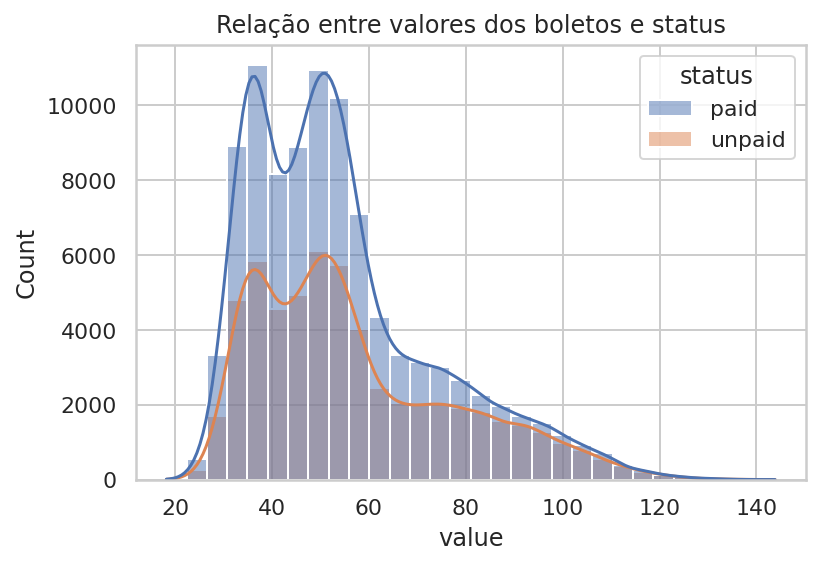

In [23]:
# Plotando a distribuição dos valores dos boletos (pagos e não pagos) 

plt.title('Relação entre valores dos boletos e status')

sns.histplot(x=charges['value'], hue=charges['status'], kde=True, bins=30)

plt.show()

Podemos observar dois picos entre R$20 e 60. São os valores mais comuns.

Até o valor R$60, a proporção de boletos não pagos é de aproximadamente 50%

A partir desse valor, esta porcentagem tende a aumentar. A maioria dos boletos que custam a partir de R$80 não são pagos.

In [24]:
# Adicionando a flag (ilicit) ao dataframe Charges

charges_ilicit = charges.merge(accounts[['account_number', 'ilicit']], how='left', on='account_number')

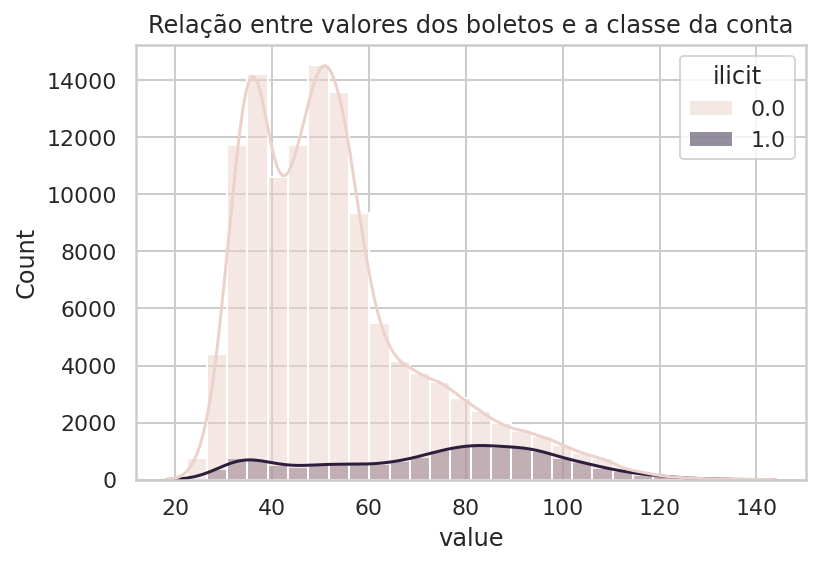

In [25]:
# Plotando a distribuição dos valores dos boletos por classe da conta 

plt.title('Relação entre valores dos boletos e a classe da conta')

sns.histplot(x=charges_ilicit['value'], hue=charges_ilicit['ilicit'], kde=True, bins=30)

plt.show()

3 detalhes chamam a atenção neste gráfico:

* Os picos observados anteriormente são reflexos de contas lícitas;
* Conta ilícitas apresentam um volume de emissões bem inferior;
* Apesar de ter certa concentração próxima a 80 reais, os valores de emissões de contas ilícitas variam muito.

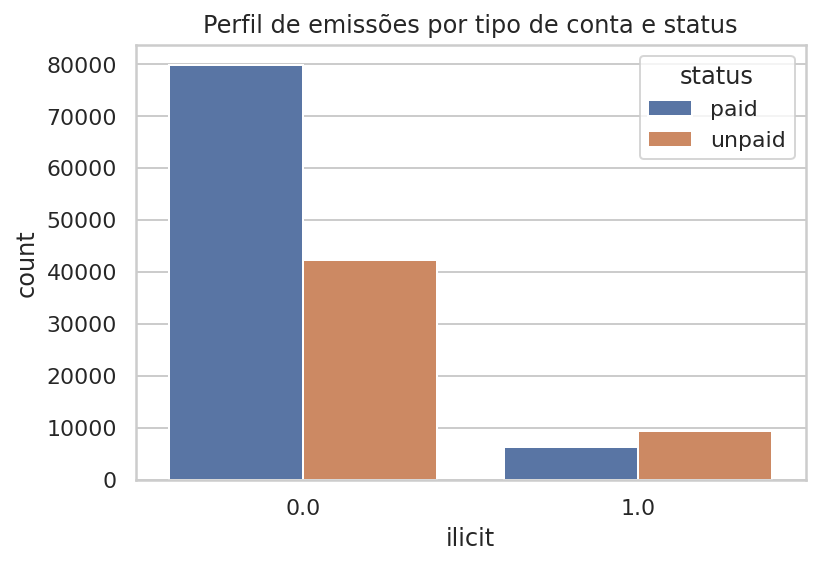

In [26]:
# Plotando o perfil de emissões por classe da conta

plt.title('Perfil de emissões por tipo de conta e status')

sns.countplot(x=charges_ilicit['ilicit'], hue=charges_ilicit['status'])

plt.show()

Percebemos que contas ilícitas tem mais emissões de boletos não pagos do que pagos.

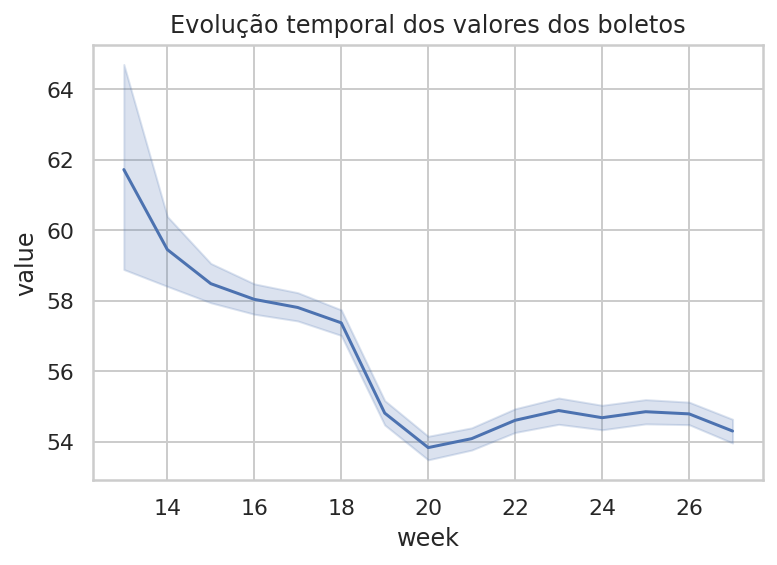

In [27]:
# Plotando a o relação entre a data e os valores de emissões dos boletos 

charges_ilicit['week'] = charges_ilicit['created_at'].dt.isocalendar().week

plt.title('Evolução temporal dos valores dos boletos')

sns.lineplot(x='week', y='value', data=charges_ilicit)

plt.show()

O intervalo dos dados vai de abril a julho. Para facilitar a visualização, as datas de emissão foram agrupadas por 'semana do ano'.

Podemos observar que no início do mês de abril, ~semana 14, houve uma maior flutuação nos valores de boleto emitidos.

Uma hipótese inicial foi que este ruído seria causado por conta ilícitas antes delas serem bloqueadas. Porém, essa hipótese foi refutada a partir da análise do gráfico seguinte, que revela que a flutuação nos valores se dá pelo tamanho reduzido da amostra nas primeiras semanas e que o volume de contas ilícitas é relativamente constante ao longo do tempo.

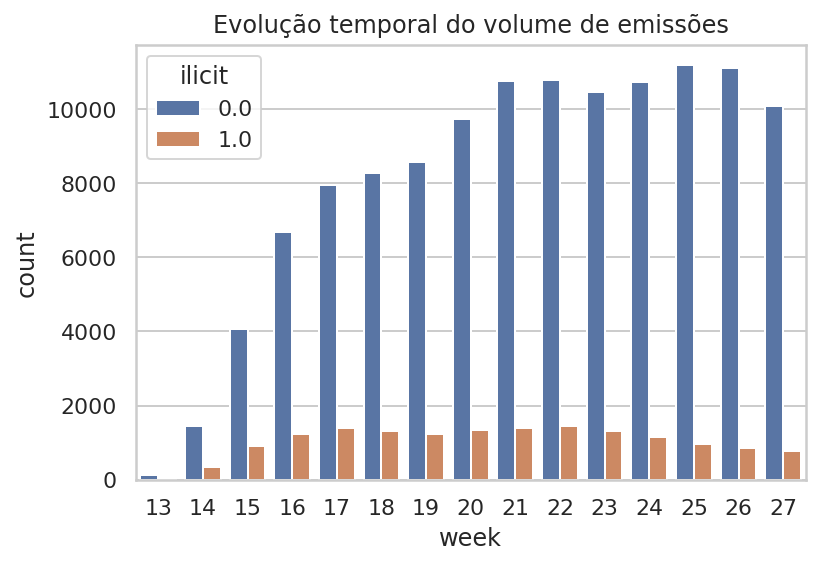

In [28]:
# Plotando a relação entre data e o volume de emissões

plt.title('Evolução temporal do volume de emissões')

sns.countplot(x=charges_ilicit['week'], hue=charges_ilicit['ilicit'])

plt.show()

###Tabela Transactions

In [29]:
# Visualizando as 3 primeiras linhas

transactions.head(3)

,account_number,value,transaction_date,description
0,155938,11992,2021-04-01 03:00:00,boleto_recebido
1,155938,9689,2021-04-01 13:30:00,boleto_recebido
2,155938,11579,2021-04-01 11:30:00,boleto_recebido


In [30]:
# Transformando os valores das transações para reais (R$) 

transactions['tran_value'] = transactions['value'] / 100

In [31]:
# Contagem de valores únicos por coluna

transactions.nunique()

account_number        880
value               21044
transaction_date     4484
description             3
tran_value          21044
dtype: int64

In [32]:
# Adicionando a flag (ilicit) ao dataframe

transactions_ilicit = transactions.merge(accounts[['account_number', 'ilicit']], how='left', on='account_number')


In [33]:
# Estatística descritiva da coluna transaction_value_real

transactions_ilicit['tran_value'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

count    256227.000000
mean         99.266882
std         284.978842
min          17.250000
5%           31.460000
10%          33.860000
25%          39.810000
50%          51.510000
75%          68.700000
90%          93.620000
95%         113.980000
max       15120.390000
Name: tran_value, dtype: float64

Nota-se que os valores são superiores aos da tabela anterior. Ressalta-se que além de boletos, essa tabela inclui transações por pix.

* A média das transações é 99,26 reais. 

* 95% dos valores são inferiores a R$113,98.

* O valor máximo é R$15.120,39, logo, provavelmente existem outliers na amostra.

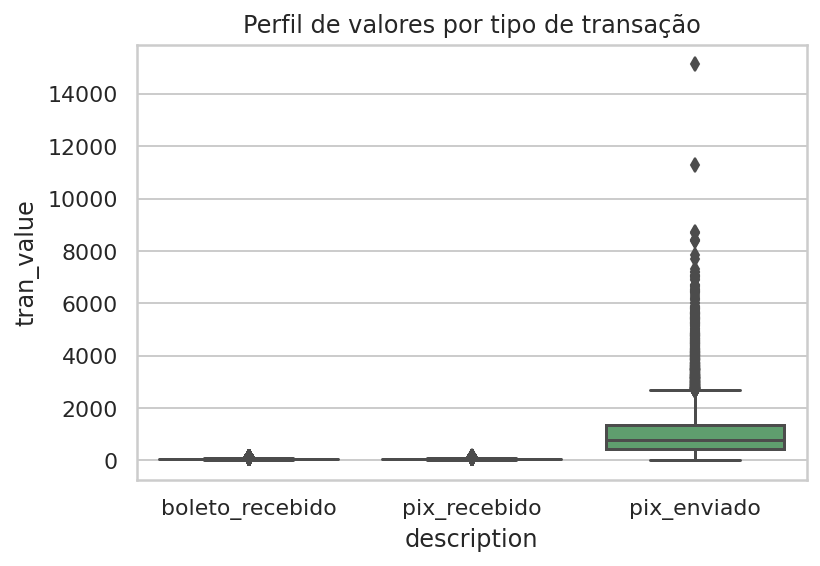

In [34]:
# Box plot dos valores transacionados

plt.title('Perfil de valores por tipo de transação')

sns.boxplot(x=transactions_ilicit['description'], y=transactions_ilicit['tran_value'])

plt.show()

O boxplot confirma a presença de outiliers e revela que os pontos mais distantes são da classe 'Pix enviado'. Os valores das outras 2 classes são inferiores a R$1.000,00

Inicialmente os outliers serão mantidos, visto que aparentemente são dados reais e não erros de digitação ou inconsistências.

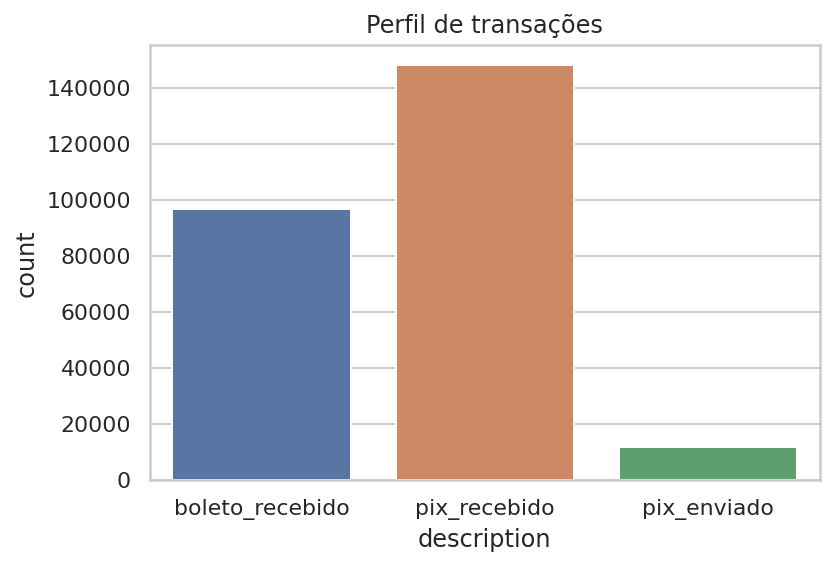

In [35]:
# Plotando o perfil de transações

plt.title('Perfil de transações')

sns.countplot(x=transactions_ilicit['description'])

plt.show()

Embora os maiores valores transacionados sejam da classe de 'Envio', os maiores volumes(contagem) são da classe de 'Recebimento'. 

O volume de 'transações recebidas' somadas é aproximadamente 16 vezes maior dos que 'transações enviadas'.

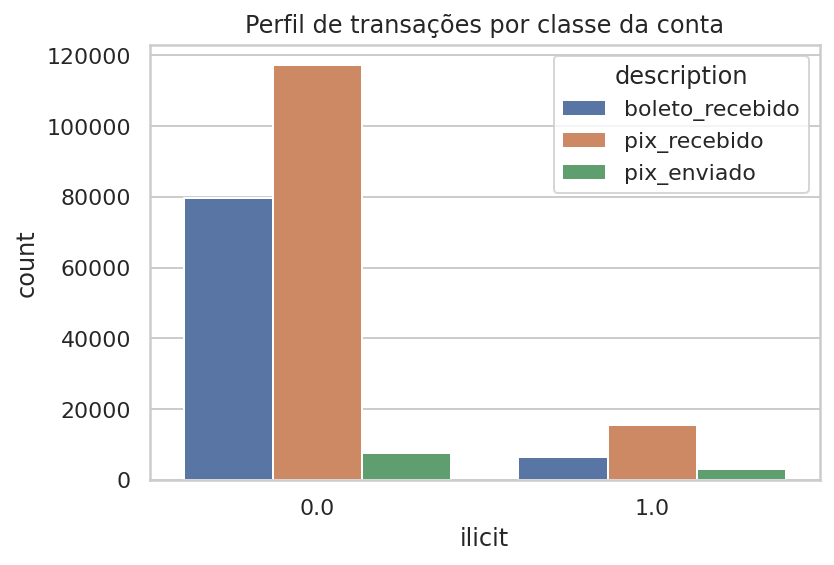

In [36]:
# Plotando o perfil de transações por classe

plt.title('Perfil de transações por classe da conta')

sns.countplot(x=transactions_ilicit['ilicit'], hue=transactions_ilicit['description'])

plt.show()

De forma similar ao que observamos para as emissões de boleto, nota-se que a quantidade de transações efetivadas em contas ilícitas é bem inferior.

Outra diferença menos sutil é na proporção de cada tipo de transação por classe da conta. Aparentemente a proporção relativa entre boleto_recebido/pix_recebido é um pouco inferior nas contas ilícitas. Por outro lado, a proporção pix_enviado/pix_recebido parece ser um pouco maior em contas dessa classe.

###Resumo

A partir dessa exploração foi possível gerar diversos insights que podem ser utilizados nas etapas de preparação e  modelagem. Dentre eles:

* O estado PR apresenta uma alta taxa de contas ilícitas;
* Certas profissões têm uma maior proporção de contas ilícitas;
* O padrão de emissões e pagamentos de boleto difere entre a classe da conta, por exemplo, contas ilícitas tem um menor volume de emissões e apresentam mais boletos não pagos do que pagos.
* Contas ilícitas apresentam um menor volume de transações e um perfil diferente. 



#3- Preparação dos dados

Nesta etapa será feita a seleção, limpeza, integração e construção de dados. Além disso, serão explorados insights que não puderam ser analisados na etapa anterior. 

## 3.1 Integração dos dados

Antes de unir as 3 tabelas é necessário agregar os valores das tabelas Charges e Transactions

### Tabela Charges

In [37]:
# One-hot encoding na coluna status

charges = pd.get_dummies(charges, columns=['status'])
charges.head(3)

,id,account_number,value,created_at,status_paid,status_unpaid
0,1,155938,119.92,2021-04-01 03:00:00,1,0
1,2,155938,96.89,2021-04-01 13:30:00,1,0
2,3,155938,115.79,2021-04-01 11:30:00,1,0


In [38]:
# Agrupando os valores da tabela Charges + Rename 

charges_group = charges.groupby('account_number').agg({'status_paid': 'sum',
                                                      'status_unpaid': 'sum',
                                                      'created_at': 'first',
                                                      'value': 'mean'}).reset_index()

charges_group = charges_group.rename(columns={'status_paid': 'status_paid_count',
                                              'status_unpaid'	: 'status_unpaid_count',
                                              'created_at': 'charges_first_date',
                                              'value': 'charges_value_mean'}) 

charges_group.head(3)

,account_number,status_paid_count,status_unpaid_count,charges_first_date,charges_value_mean
0,2711,144.0,75.0,2021-06-19 13:30:00,88.283607
1,2763,128.0,95.0,2021-05-05 11:30:00,59.012511
2,2957,32.0,30.0,2021-06-04 06:30:00,89.009355


###Tabela Transactions

In [39]:
# One-hot encoding na coluna description

transactions = pd.get_dummies(transactions, columns=['description'])
transactions.head(3)

,account_number,value,transaction_date,tran_value,description_boleto_recebido,description_pix_enviado,description_pix_recebido
0,155938,11992,2021-04-01 03:00:00,119.92,1,0,0
1,155938,9689,2021-04-01 13:30:00,96.89,1,0,0
2,155938,11579,2021-04-01 11:30:00,115.79,1,0,0


In [40]:
# Agrupando os valores da tabela Transactions + Rename

transactions_group = transactions.groupby('account_number').agg({'description_boleto_recebido': 'sum',
                                                      'description_pix_enviado': 'sum',
                                                      'description_pix_recebido': 'sum',
                                                      'transaction_date': 'first',
                                                      'tran_value': 'mean'}).reset_index()

transactions_group = transactions_group.rename(columns={'description_boleto_recebido': 'boleto_recebido_count',
                                                        'description_pix_enviado' : 'pix_enviado_count',
                                                        'description_pix_recebido': 'pix_recebido_count',
                                                        'transaction_date': 'transaction_first_date',
                                                        'tran_value': 'transactions_value_mean'})

transactions_group.head(3)

,account_number,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transaction_first_date,transactions_value_mean
0,2711,144.0,9,193.0,2021-06-19 13:30:00,164.029191
1,2763,128.0,11,171.0,2021-05-05 05:00:00,104.828548
2,2957,32.0,18,60.0,2021-06-04 06:30:00,145.713000


### Merge das tabelas: Accounts, Charges e Transactions

In [41]:
# Unindo as tabelas

accounts_charges = accounts.merge(charges_group, how='left', on='account_number')

df_merge = accounts_charges.merge(transactions_group, how='left', on='account_number')

df_merge.head(3)

,id,account_number,birth,occupation,created_at,state,level,ilicit,status_paid_count,status_unpaid_count,charges_first_date,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transaction_first_date,transactions_value_mean
0,1,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,F,1.0,30.0,39.0,2021-04-01 03:00:00,112.151594,30.0,15.0,66.0,2021-04-01 03:00:00,190.434955
1,2,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,D,0.0,113.0,153.0,2021-04-02 12:00:00,33.380564,113.0,10.0,172.0,2021-04-02 19:00:00,53.127390
2,3,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,None,NaN,64.0,79.0,2021-04-02 05:30:00,54.264895,64.0,8.0,156.0,2021-04-02 15:30:00,104.648377


##3.2 Feature Engineering


###Criando variáveis com informações temporais

In [42]:
# Calculando a idade aproximada dos clientes ao abrirem a conta

df_merge['idade'] = (df_merge['created_at'].dt.year) - (df_merge['birth'].dt.year)

In [43]:
# Intervalo em horas entre a criação da conta e efetivação da 1ª transação

df_merge['hours_to_transaction'] = (df_merge['transaction_first_date'] - df_merge['created_at']) / np.timedelta64(1, 'h')

df_merge.head(3)

,id,account_number,birth,occupation,created_at,state,level,ilicit,status_paid_count,status_unpaid_count,charges_first_date,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transaction_first_date,transactions_value_mean,idade,hours_to_transaction
0,1,155938,1984-10-29,Outros,2021-04-01 02:30:00,RJ,F,1.0,30.0,39.0,2021-04-01 03:00:00,112.151594,30.0,15.0,66.0,2021-04-01 03:00:00,190.434955,37,0.5
1,2,747007,1977-03-26,Corretor,2021-04-01 02:00:00,MG,D,0.0,113.0,153.0,2021-04-02 12:00:00,33.380564,113.0,10.0,172.0,2021-04-02 19:00:00,53.127390,44,41.0
2,3,208404,1984-01-26,Analista,2021-04-01 11:30:00,MG,None,NaN,64.0,79.0,2021-04-02 05:30:00,54.264895,64.0,8.0,156.0,2021-04-02 15:30:00,104.648377,37,28.0


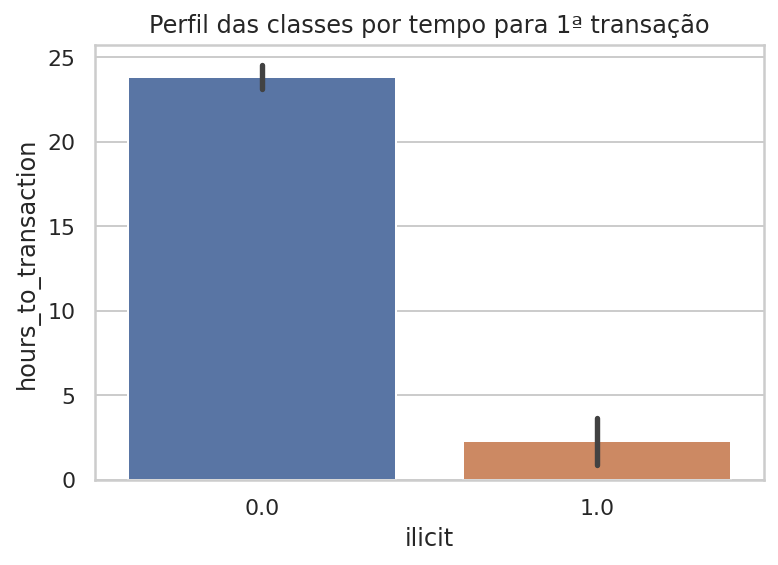

In [44]:
# Perfil das classes por tempo para 1ª transação

plt.title('Perfil das classes por tempo para 1ª transação')

sns.barplot(data=df_merge,x='ilicit', y='hours_to_transaction');

Nota-se que o intervalo entre a abertura da conta e as primeiras transações é em média de ~24 horas para contas lícitas e menos de 5 horas para conta ilícitas.

### One-hot enconding na variável 'profissões'

In [45]:
# One-hot encoding na coluna Occupation

df_merge = pd.get_dummies(df_merge, columns=['occupation'])

## 3.3 Tratamento de nulos

In [46]:
# Removendo colunas desnecessárias para o modelo

df = df_merge.drop(columns=['id', 'account_number', 'birth', 'created_at', 'state','level', 'charges_first_date', 'transaction_first_date'])

In [47]:
# Dimensões, formatos e nulos

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029 entries, 0 to 1028
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ilicit                    926 non-null    float64
 1   status_paid_count         880 non-null    float64
 2   status_unpaid_count       880 non-null    float64
 3   charges_value_mean        880 non-null    float64
 4   boleto_recebido_count     880 non-null    float64
 5   pix_enviado_count         880 non-null    float64
 6   pix_recebido_count        880 non-null    float64
 7   transactions_value_mean   880 non-null    float64
 8   idade                     1029 non-null   int64  
 9   hours_to_transaction      880 non-null    float64
 10  occupation_Analista       1029 non-null   uint8  
 11  occupation_Autonomo       1029 non-null   uint8  
 12  occupation_Corretor       1029 non-null   uint8  
 13  occupation_Desenvolvedor  1029 non-null   uint8  
 14  occupati

Considerando que algumas contas não possuem dados de transações, resolvi substituir os nulos por 0. 


Outras possíveis opções  de tratamento seriam: remover as linhas  ou colunas nulas, preencher nulos com a média geral ou média por profissão, etc.

In [48]:
# Preenchendo registros sem classificação com: 'indefinido'

df['ilicit'] = df['ilicit'].apply(lambda x: x if x in (1.0, 0.0) else 'indefinido')

Isso foi feito para que a linha de código abaixo preencha com 0 apenas os valores nulos em relação aos dados de transações e não em relação a classe(lícita/ilícita).

In [49]:
# Preenchendo os valores nulos com 0

df = df.fillna(0)

In [50]:
# Confirmando o número de nulos após o tratamento

df.isnull().sum()

ilicit                      0
status_paid_count           0
status_unpaid_count         0
charges_value_mean          0
boleto_recebido_count       0
pix_enviado_count           0
pix_recebido_count          0
transactions_value_mean     0
idade                       0
hours_to_transaction        0
occupation_Analista         0
occupation_Autonomo         0
occupation_Corretor         0
occupation_Desenvolvedor    0
occupation_Investidor       0
occupation_Outros           0
dtype: int64

In [51]:
# Dataframe após o tratamento de nulos

df.head(3)

,ilicit,status_paid_count,status_unpaid_count,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transactions_value_mean,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros
0,1.0,30.0,39.0,112.151594,30.0,15.0,66.0,190.434955,37,0.5,0,0,0,0,0,1
1,0.0,113.0,153.0,33.380564,113.0,10.0,172.0,53.127390,44,41.0,0,0,1,0,0,0
2,indefinido,64.0,79.0,54.264895,64.0,8.0,156.0,104.648377,37,28.0,1,0,0,0,0,0


## 3.4 Padronização das variáveis

In [52]:
from sklearn.preprocessing import StandardScaler
# Padronizando as variáveis preditoras

x_bruto = df.drop(columns=['ilicit'])
scaler = StandardScaler().fit(x_bruto)
x_std = pd.DataFrame(scaler.transform(x_bruto), columns=x_bruto.columns.values)

In [53]:
# Concatenando os dados: Xs padronizados + y

df = pd.concat([x_std, df['ilicit']], axis=1)
df.head(3)

,status_paid_count,status_unpaid_count,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transactions_value_mean,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros,ilicit
0,-0.647144,-0.290363,2.211392,-0.647144,0.441352,-0.543806,2.129946,-0.031965,-1.115830,-0.562011,-0.255377,-0.515444,-0.522986,-0.358175,2.288310,1.0
1,0.191344,1.650344,-0.584904,0.191344,-0.136008,0.197410,-0.686537,0.622142,1.846341,-0.562011,-0.255377,1.940074,-0.522986,-0.358175,-0.437004,0.0
2,-0.303667,0.390587,0.156470,-0.303667,-0.366952,0.085529,0.370273,-0.031965,0.895521,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,indefinido


##3.4 Seleção de dados

### Separando o dataset a depender da classe

Registros com a classe conhecida serão utilizados na etapa de modelagem.

Os demais registros terão suas classes preditas com base no modelo.

In [54]:
# Registros sem classificação conhecida

df_indefinido = df.loc[df['ilicit'] == 'indefinido']
df_indefinido.head(3) 

,status_paid_count,status_unpaid_count,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transactions_value_mean,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros,ilicit
2,-0.303667,0.390587,0.156470,-0.303667,-0.366952,0.085529,0.370273,-0.031965,0.895521,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,indefinido
6,0.736867,-0.239292,0.031640,0.736867,0.210408,-0.515836,0.153388,0.154923,0.017841,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,indefinido
7,2.585583,5.599852,-0.453761,2.585583,4.944758,4.057332,-0.350846,-0.592629,-0.238149,-0.562011,-0.255377,-0.515444,1.912095,-0.358175,-0.437004,indefinido


In [55]:
# Registros com classificação conhecida

df_modelo = df.loc[df['ilicit'] != 'indefinido']
df_modelo['ilicit'] = df_modelo['ilicit'].astype(int)
df_modelo.head(3)

,status_paid_count,status_unpaid_count,charges_value_mean,boleto_recebido_count,pix_enviado_count,pix_recebido_count,transactions_value_mean,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros,ilicit
0,-0.647144,-0.290363,2.211392,-0.647144,0.441352,-0.543806,2.129946,-0.031965,-1.115830,-0.562011,-0.255377,-0.515444,-0.522986,-0.358175,2.288310,1
1,0.191344,1.650344,-0.584904,0.191344,-0.136008,0.197410,-0.686537,0.622142,1.846341,-0.562011,-0.255377,1.940074,-0.522986,-0.358175,-0.437004,0
3,0.908606,-0.392506,0.828784,0.908606,-0.713368,0.155455,0.467728,0.154923,-0.347859,-0.562011,-0.255377,-0.515444,-0.522986,2.791930,-0.437004,0


### Remoção de variáveis altamente correlacionadas

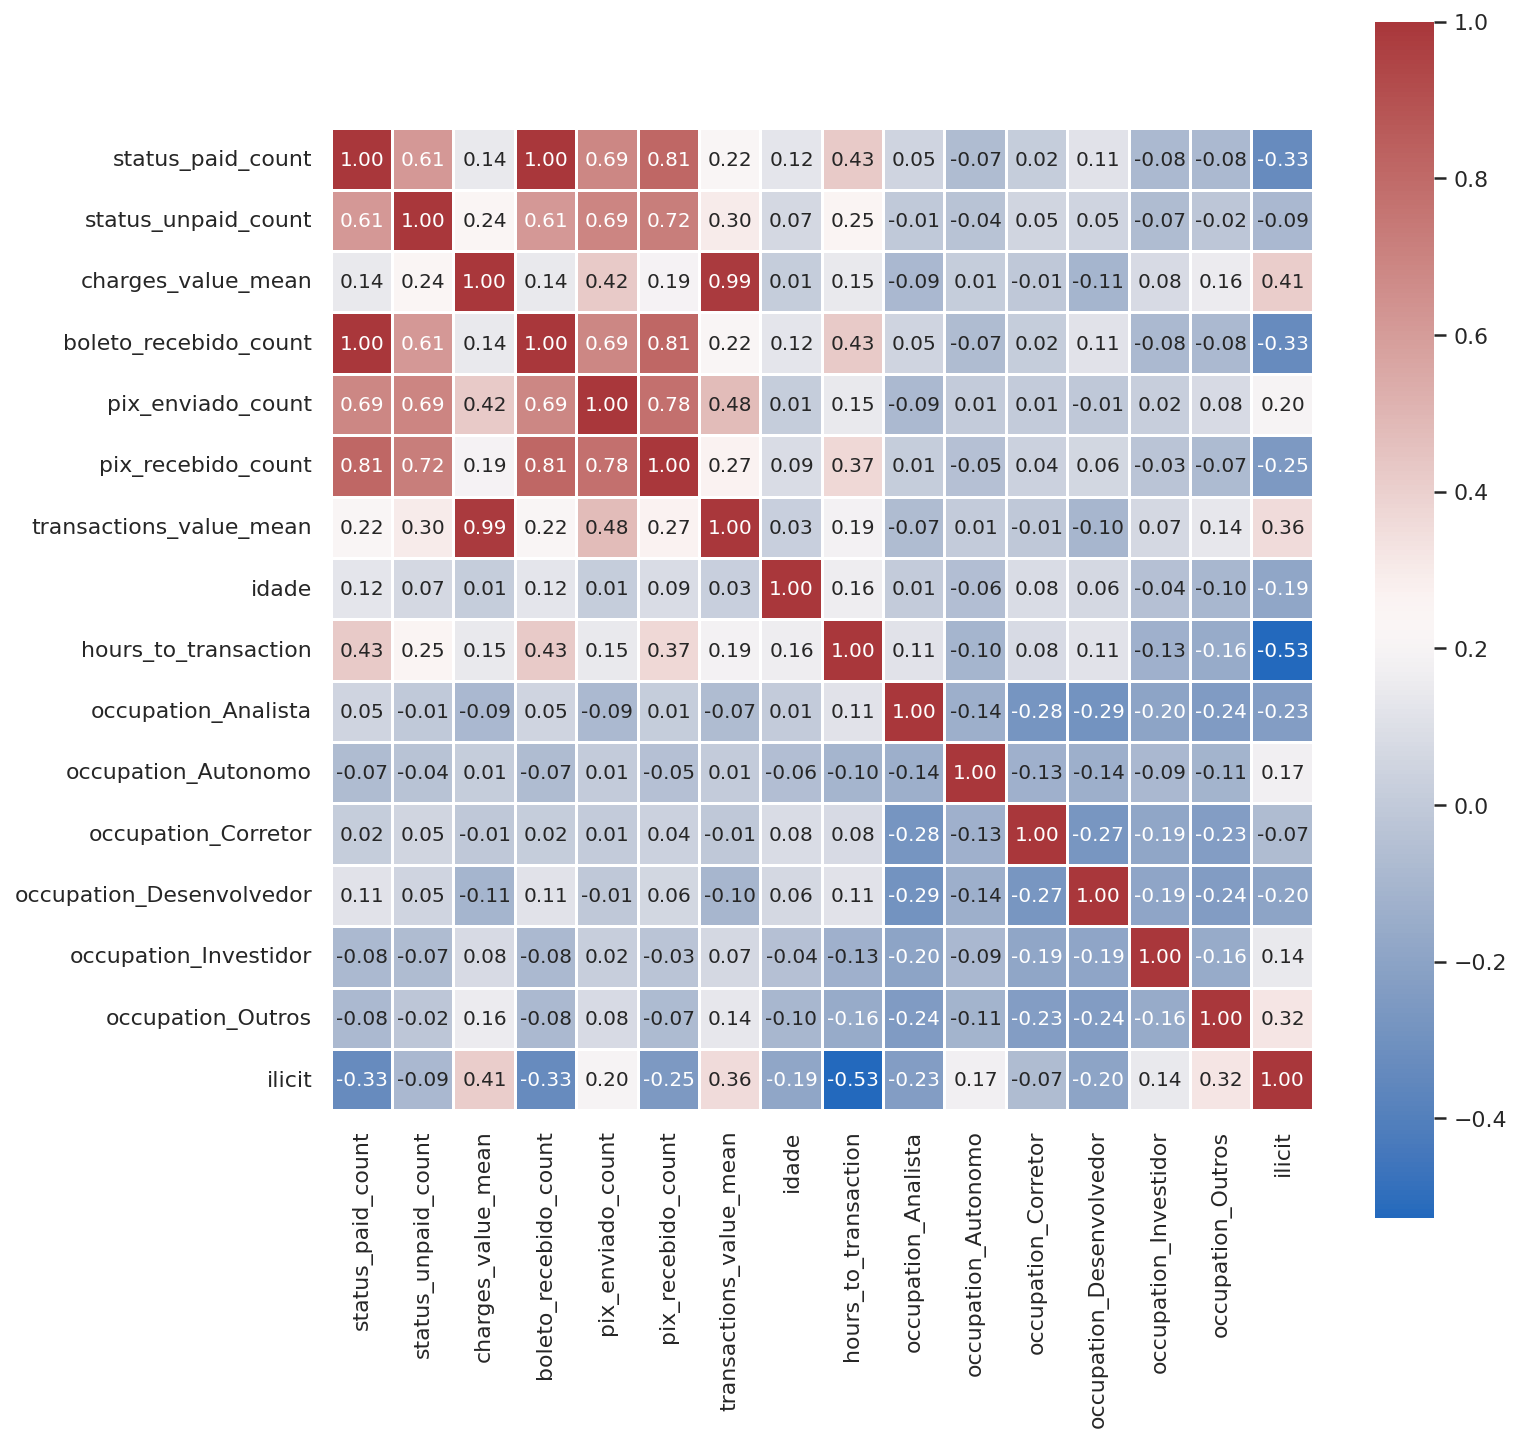

In [56]:
# Analisando as correlações

heat = df_modelo.corr()

plt.figure(figsize=(11,11))

sns.heatmap(heat, cmap='vlag', square=True, linewidth=1, annot=True, annot_kws={'fontsize':'small'}, fmt='.2f');

Podemos observar que algumas colunas apresentam correlação moderada com a variável alvo, destacando-se: hours_to_transaction (-0.53) e charges_value_mean (0.41).

Ressalta-se que a variável que apresenta maior correlação com o alvo não estava presente na tabela original. Ela foi construída ao longo da análise a partir dos insights gerados na EDA e da aplicação de técnicas de feature engineering.

Nota-se também que algumas variáveis são altamente correlacionadas entre si, e isso poderia prejudicar o desempenho dos modelos. Nesse sentido, apliquei um filtro e removi as variáveis com correlação superiores a 0.9

In [57]:
# Identificando as variáveis altamente correlacionadas

cor_matrix = df_modelo.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

['boleto_recebido_count', 'transactions_value_mean']


In [58]:
# Removendo as variáveis altamente correlacionadas 

df_modelo = df_modelo.drop(columns=to_drop)
df_modelo.head()

,status_paid_count,status_unpaid_count,charges_value_mean,pix_enviado_count,pix_recebido_count,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros,ilicit
0,-0.647144,-0.290363,2.211392,0.441352,-0.543806,-0.031965,-1.115830,-0.562011,-0.255377,-0.515444,-0.522986,-0.358175,2.288310,1
1,0.191344,1.650344,-0.584904,-0.136008,0.197410,0.622142,1.846341,-0.562011,-0.255377,1.940074,-0.522986,-0.358175,-0.437004,0
3,0.908606,-0.392506,0.828784,-0.713368,0.155455,0.154923,-0.347859,-0.562011,-0.255377,-0.515444,-0.522986,2.791930,-0.437004,0
4,-0.041008,0.952370,0.031378,-0.251480,0.106507,1.556581,1.078371,-0.562011,-0.255377,-0.515444,-0.522986,-0.358175,2.288310,0
5,-0.950213,-0.954289,-1.769882,-1.290727,-1.005319,0.061479,-1.152400,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,0


#4- Modelling

##4.1 Abordagem adotada

* Modelos testados: Regressão logística, SVC e Floresta aleatória.

* Divisão treino/teste: 75/25

* Cross_validation (K-fold): 5

* Métricas: acurácia, f1-score, roc-auc

##4.2 Divisão treino/teste

In [59]:
#from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix
#from sklearn.model_selection import train_test_split

X = df_modelo.drop('ilicit', axis=1)
y = df_modelo['ilicit']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

##4.3 Construção e avaliação dos modelos

### Regressão Logística

In [60]:
clf_log = LogisticRegression(random_state=7)
scores = cross_val_score(clf_log, x_train, y_train, cv=5, scoring='f1')

clf_log = clf_log.fit(x_train, y_train)

y_log= clf_log.predict(x_test)

print(f'CV (F1 score): {scores.mean():.2f}. Desvio padrão: {scores.std():.2f}.')
print(f'Teste (F1 score): {f1_score(y_test,y_log):.2f}')
print(f'Teste (Acurácia): {accuracy_score(y_test, y_log):.2f}')
print(f'Teste (ROC-AUC): {roc_auc_score(y_test,y_log):.2f}')

CV (F1 score): 0.94. Desvio padrão: 0.03.
Teste (F1 score): 0.94
Teste (Acurácia): 0.97
Teste (ROC-AUC): 0.96


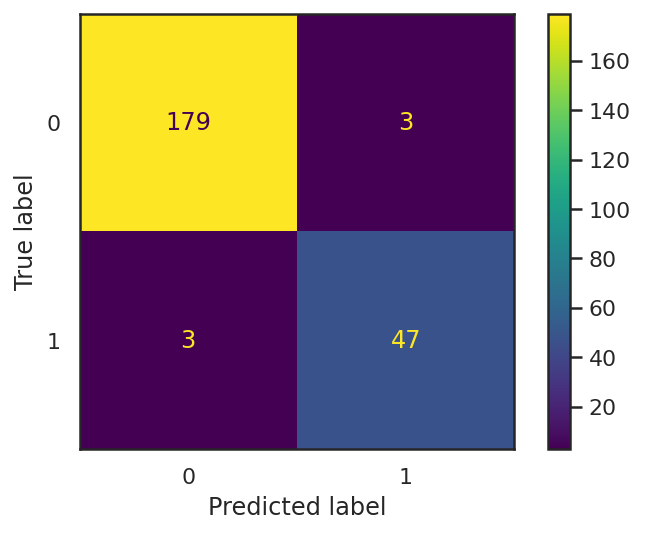

In [61]:
sns.set_theme(style="white")
plot_confusion_matrix(clf_log, x_test, y_test);

### Support Vector Classifier

In [62]:
clf_svc = SVC(kernel='linear', random_state=7)
scores = cross_val_score(clf_svc, x_train, y_train, cv=5, scoring='f1')

clf_svc = clf_svc.fit(x_train, y_train)

y_svc= clf_svc.predict(x_test)

print(f'CV (F1 score): {scores.mean():.2f}. Desvio padrão: {scores.std():.2f}.')
print(f'Teste (F1 score): {f1_score(y_test,y_svc):.2f}')
print(f'Teste (Acurácia): {accuracy_score(y_test, y_svc):.2f}')
print(f'Teste (ROC-AUC): {roc_auc_score(y_test,y_svc):.2f}')

CV (F1 score): 0.93. Desvio padrão: 0.03.
Teste (F1 score): 0.93
Teste (Acurácia): 0.97
Teste (ROC-AUC): 0.96


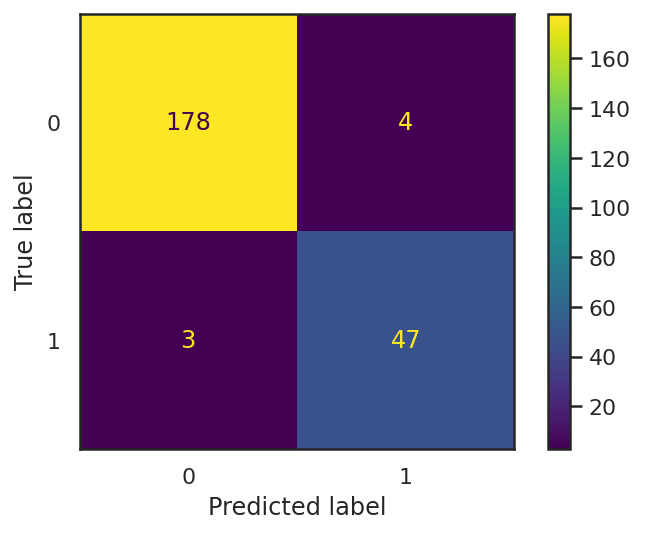

In [63]:
plot_confusion_matrix(clf_svc, x_test, y_test);

### Floresta Aleatória

In [64]:
clf_tree = RandomForestClassifier(max_depth=5, random_state=7)
scores = cross_val_score(clf_tree, x_train, y_train, cv=5, scoring='f1')

clf_tree = clf_tree.fit(x_train, y_train)

y_tree = clf_tree.predict(x_test)

print(f'CV (F1 score): {scores.mean():.2f}. Desvio padrão: {scores.std():.2f}.')
print(f'Teste (F1 score): {f1_score(y_test,y_tree):.2f}')
print(f'Teste (Acurácia): {accuracy_score(y_test, y_tree):.2f}')
print(f'Teste (ROC-AUC): {roc_auc_score(y_test,y_tree):.2f}')

CV (F1 score): 0.92. Desvio padrão: 0.02.
Teste (F1 score): 0.93
Teste (Acurácia): 0.97
Teste (ROC-AUC): 0.94


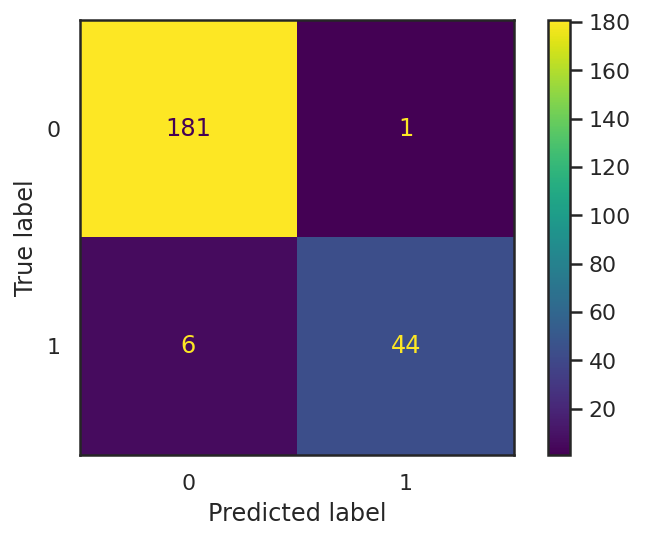

In [65]:
plot_confusion_matrix(clf_tree, x_test, y_test);

##4.4 Seleção do melhor modelo

De modo geral, as métricas de avaliação foram semelhantes entre os modelos testados.

Selecionei o modelo de **Regressão Logística**, devido a sua menor complexidade e pelo fato dele apresentar métricas ligeiramente superiores.

In [66]:
# Retreinando o modelo com a base completa

modelo_final = LogisticRegression(random_state=7).fit(X, y)

#5- Produção

### Aplicando o modelo em registros sem classificação

In [67]:
# Removendo a coluna Target e as 2 colunas altamente correlacionaadas.

df_indefinido = df_indefinido.drop(columns=['boleto_recebido_count', 'transactions_value_mean', 'ilicit'])
df_indefinido.head(3)

,status_paid_count,status_unpaid_count,charges_value_mean,pix_enviado_count,pix_recebido_count,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros
2,-0.303667,0.390587,0.156470,-0.366952,0.085529,-0.031965,0.895521,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004
6,0.736867,-0.239292,0.031640,0.210408,-0.515836,0.154923,0.017841,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004
7,2.585583,5.599852,-0.453761,4.944758,4.057332,-0.592629,-0.238149,-0.562011,-0.255377,-0.515444,1.912095,-0.358175,-0.437004


In [68]:
# Aplicando o modelo em registros com classe desconhecida

df_indefinido['fraud'] = modelo_final.predict(df_indefinido)
df_indefinido

,status_paid_count,status_unpaid_count,charges_value_mean,pix_enviado_count,pix_recebido_count,idade,hours_to_transaction,occupation_Analista,occupation_Autonomo,occupation_Corretor,occupation_Desenvolvedor,occupation_Investidor,occupation_Outros,fraud
2,-0.303667,0.390587,0.156470,-0.366952,0.085529,-0.031965,0.895521,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,0
6,0.736867,-0.239292,0.031640,0.210408,-0.515836,0.154923,0.017841,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,0
7,2.585583,5.599852,-0.453761,4.944758,4.057332,-0.592629,-0.238149,-0.562011,-0.255377,-0.515444,1.912095,-0.358175,-0.437004,0
8,3.919083,2.280222,0.143324,3.905511,6.134137,0.248366,0.456681,-0.562011,-0.255377,-0.515444,-0.522986,2.791930,-0.437004,0
51,0.342878,0.322492,-0.105912,-0.020536,-0.019360,0.341810,0.712671,-0.562011,-0.255377,1.940074,-0.522986,-0.358175,-0.437004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,-0.677451,-0.801075,0.734250,-0.944311,-0.767570,-0.872960,1.151511,-0.562011,3.915780,-0.515444,-0.522986,-0.358175,-0.437004,0
978,-0.950213,-0.954289,-1.769882,-1.290727,-1.005319,1.556581,-1.152400,-0.562011,-0.255377,-0.515444,1.912095,-0.358175,-0.437004,0
993,-0.839088,-0.784052,1.529889,-1.290727,-0.872459,0.995918,0.822381,1.779323,-0.255377,-0.515444,-0.522986,-0.358175,-0.437004,0
1008,-0.930008,-0.852147,1.143036,-1.059783,-0.949378,0.715586,-0.420999,-0.562011,-0.255377,-0.515444,-0.522986,-0.358175,2.288310,1


In [69]:
# Criando um df com o número da conta e predições

df_results = pd.merge(df_merge['account_number'], df_indefinido['fraud'], left_index=True, right_index=True)
df_results

,account_number,fraud
2,208404,0
6,108762,0
7,309054,0
8,89836,0
51,900180,0
...,...,...
977,905598,0
978,886210,0
993,583343,0
1008,81888,1


In [70]:
# Exportando os resultados para um arquivo csv

df_results.to_csv('classificacao_obtida.csv', index=False)